In [197]:
# imports 
import numpy as np
import os, sys
import monai
from monai.data import CacheDataset, DataLoader, GridPatchDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    MapLabelValued,
    LoadImage,
    Rotated,
    Flipd,
    SpatialPadd,
    
)

from monai.networks.nets import UNet

import math
import matplotlib.pyplot as plt
import glob
import torch
import SimpleITK as sitk

In [198]:
data_dir = "../../MMWHS_Dataset/ct_train"
images = sorted(glob.glob(os.path.join(data_dir, "ct_train_1015_image.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "ct_train_1015_label.nii.gz")))

example_dataset = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))
case = 1015

1


In [199]:
volume_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"), # normalization between 0 and 1
        EnsureTyped(keys=["img", "seg"]),   
    ]
)

In [200]:
volume_ds_person1 = CacheDataset(data=example_dataset, transform=volume_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(volume_ds_person1, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

Loading dataset: 100%|██████████| 1/1 [01:03<00:00, 63.26s/it]


In [201]:
print("fourth volume's shape", check_data["img"].shape, check_data["seg"].shape)


fourth volume's shape torch.Size([1, 1, 512, 512, 358]) torch.Size([1, 1, 512, 512, 358])


In [206]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["img", "seg"], dim=-1),  # squeeze the last dim
        #Rotated(keys=["img", "seg"], angle=math.radians(180)),
        Flipd(keys=["img", "seg"], spatial_axis=1),
        Resized(keys=["img"], spatial_size=[256,256], mode="bilinear"),
        Resized(keys=["seg"], spatial_size=[256,256], mode="nearest"),
        MapLabelValued(keys=["seg"], orig_labels=[205, 420, 500, 550, 600, 820, 850], target_labels=[1, 2, 3, 4, 5 , 6 , 7]), 
    ]
)

filenames = [f"{case}_slice_orig.nii.gz", f"{case}_slice_orig_map.nii.gz", f"{case}_slice_orig_map_flip.nii.gz", f"{case}_slice_orig_map_flip_resize.nii.gz"]
filename = filenames[3]

example_patch_ds = GridPatchDataset(data=volume_ds_person1, patch_iter=patch_func, transform=patch_transform)
patch_data_loader = DataLoader(example_patch_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())


In [207]:
i = 1
current_directory = os.getcwd()
output_dir_image = "../preprocessed/ct_examples/images"
output_dir_label = "../preprocessed/ct_examples/labels"

os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)

j=0
for batch in patch_data_loader:
    image, label = batch[0]["img"], batch[0]["seg"]
    j += 1
    if j > 110: 
        image = image.squeeze(0)
        label = label.squeeze(0)
        print("image shape", image.shape, "label shape", label.shape)

        # Convert the torch tensor to a SimpleITK image
        slice_image = sitk.GetImageFromArray(image)
        slice_label = sitk.GetImageFromArray(label)
        # # Save the 2D slice as a NIfTI file
        sitk.WriteImage(slice_image, os.path.join(output_dir_image, filename))
        sitk.WriteImage(slice_label, os.path.join(output_dir_label, filename))
        i += 1
        break

print("Total number of slices:", i)

image shape torch.Size([1, 256, 256]) label shape torch.Size([1, 256, 256])
Total number of slices: 2


image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


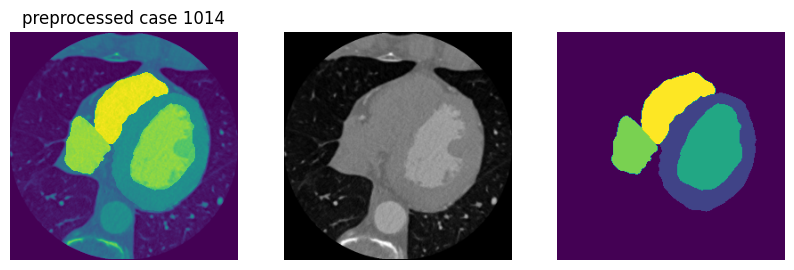

In [208]:
# original, mapped, flipped, resized
file_original_map_flip_res = f"../preprocessed/ct_examples/images/{case}_slice_orig_map_flip_resize.nii.gz"
example_im_original_map_flip_res = LoadImage(image_only=True, simple_keys=True)(file_original_map_flip_res)
print(f"image data shape: {example_im_original_map_flip_res.shape}")

label_original_map_flip_res = f"../preprocessed/ct_examples/labels/{case}_slice_orig_map_flip_resize.nii.gz"
example_label_original_map_flip_res = LoadImage(image_only=True, simple_keys=True)(label_original_map_flip_res)
print(f"label data shape: {example_label_original_map_flip_res.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title(f"preprocessed case {case}")
plt.axis("off")
plt.imshow((example_im_original_map_flip_res + example_label_original_map_flip_res/10) / 2)
plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(example_im_original_map_flip_res, cmap="gray")
plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(example_label_original_map_flip_res)

In [205]:
d

NameError: name 'd' is not defined

image data shape: torch.Size([512, 512, 1])
label data shape: torch.Size([512, 512, 1])


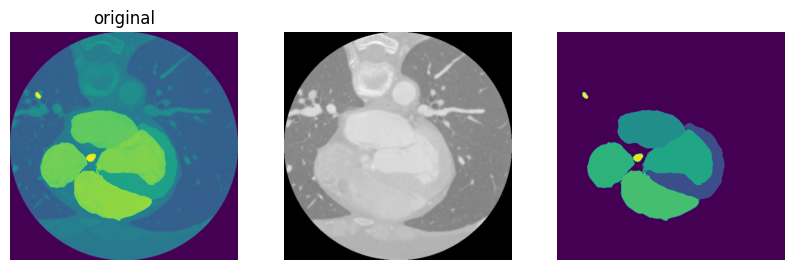

In [ ]:
# original
file_original = f"../preprocessed/ct_examples/images/{case}_slice_orig.nii.gz"
example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
print(f"image data shape: {example_im_original.shape}")

label_original = f"../preprocessed/ct_examples/labels/{case}_slice_orig.nii.gz"
example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
print(f"label data shape: {example_label_original.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("original case = 1006")
plt.axis("off")
plt.imshow((example_im_original + example_label_original/1000) / 2)
plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(example_im_original, cmap="gray")
plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(example_label_original)

In [ ]:
# original
file_original = f"../preprocessed/ct_examples/images/{case}_slice_orig.nii.gz"
example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
print(f"image data shape: {example_im_original.shape}")

label_original = f"../preprocessed/ct_examples/labels/{case}_slice_orig.nii.gz"
example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
print(f"label data shape: {example_label_original.shape}")

# original and mapped
file_original_map = f"../preprocessed/ct_examples/images/{case}_slice_orig_map.nii.gz"
example_im_original_map = LoadImage(image_only=True, simple_keys=True)(file_original_map)
print(f"image data shape: {example_im_original_map.shape}")

label_original_map = f"../preprocessed/ct_examples/labels/{case}_slice_orig_map.nii.gz"
example_label_original_map = LoadImage(image_only=True, simple_keys=True)(label_original_map)
print(f"label data shape: {example_label_original_map.shape}")

# original, mapped and flipped
file_original_map_flip = f"../preprocessed/ct_examples/images/{case}_slice_orig_map_flip.nii.gz"
example_im_original_map_flip = LoadImage(image_only=True, simple_keys=True)(file_original_map_flip)
print(f"image data shape: {example_im_original_map_flip.shape}")

label_original_map_flip = f"../preprocessed/ct_examples/labels/{case}_slice_orig_map_flip.nii.gz"
example_label_original_map_flip = LoadImage(image_only=True, simple_keys=True)(label_original_map_flip)
print(f"label data shape: {example_label_original_map_flip.shape}")


# original, mapped, flipped, resized
file_original_map_flip_res = f"../preprocessed/ct_examples/images/{case}_slice_orig_map_flip_resize.nii.gz"
example_im_original_map_flip_res = LoadImage(image_only=True, simple_keys=True)(file_original_map_flip_res)
print(f"image data shape: {example_im_original_map_flip_res.shape}")

label_original_map_flip_res = f"../preprocessed/ct_examples/labels/{case}_slice_orig_map_flip_resize.nii.gz"
example_label_original_map_flip_res = LoadImage(image_only=True, simple_keys=True)(label_original_map_flip_res)
print(f"label data shape: {example_label_original_map_flip_res.shape}")


image data shape: torch.Size([512, 512, 1])
label data shape: torch.Size([512, 512, 1])
image data shape: torch.Size([512, 512, 1])
label data shape: torch.Size([512, 512, 1])
image data shape: torch.Size([512, 512, 1])
label data shape: torch.Size([512, 512, 1])
image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


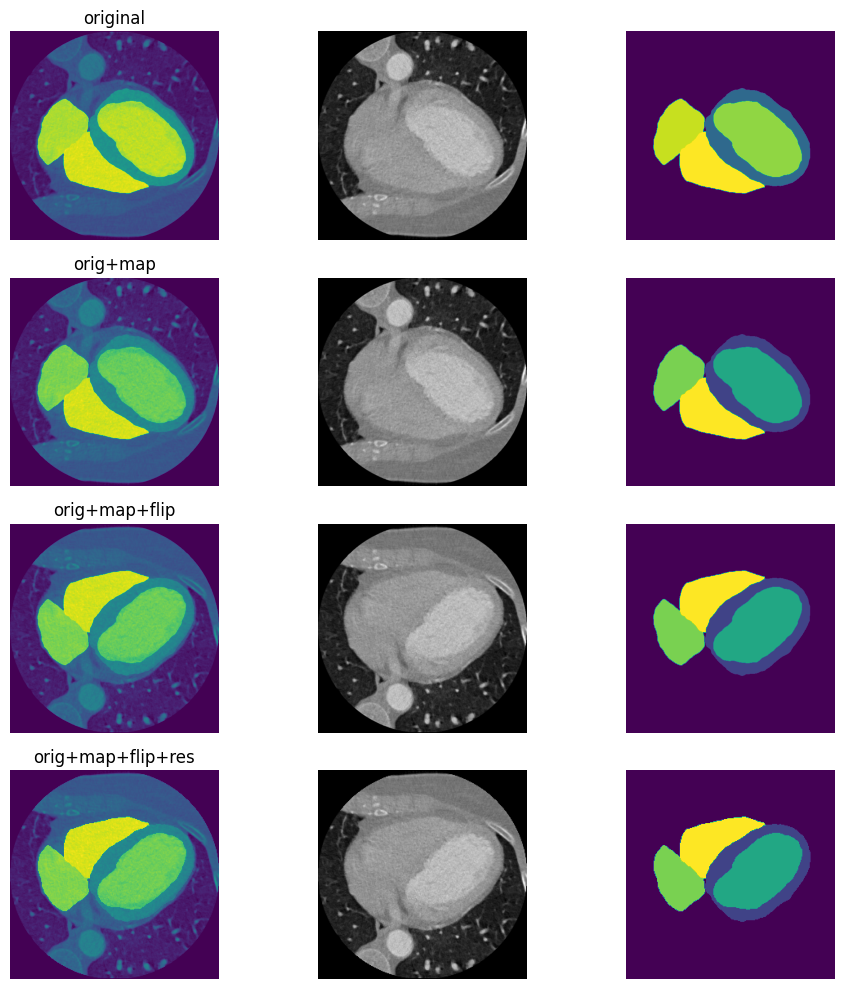

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 3, 1)
plt.title("original")
plt.axis("off")
plt.imshow((example_im_original + example_label_original/1000) / 2)
plt.subplot(4, 3, 2)
plt.axis("off")
plt.imshow(example_im_original, cmap="gray")
plt.subplot(4, 3, 3)
plt.axis("off")
plt.imshow(example_label_original)

plt.subplot(4, 3, 4)
plt.title("orig+map")
plt.axis("off")
plt.imshow((example_im_original_map + example_label_original_map/10) / 2)
plt.subplot(4, 3, 5)
plt.axis("off")
plt.imshow(example_im_original_map, cmap="gray")
plt.subplot(4, 3, 6)
plt.axis("off")
plt.imshow(example_label_original_map)

plt.subplot(4, 3, 7)
plt.title("orig+map+flip")
plt.axis("off")
plt.imshow((example_im_original_map_flip + example_label_original_map_flip/10) / 2)
plt.subplot(4, 3, 8)
plt.axis("off")
plt.imshow(example_im_original_map_flip, cmap="gray")
plt.subplot(4, 3, 9)
plt.axis("off")
plt.imshow(example_label_original_map_flip)

plt.subplot(4, 3, 10)
plt.title("orig+map+flip+res")
plt.axis("off")
plt.imshow((example_im_original_map_flip_res + example_label_original_map_flip_res/10) / 2)
plt.subplot(4, 3, 11)
plt.axis("off")
plt.imshow(example_im_original_map_flip_res, cmap="gray")
plt.subplot(4, 3, 12)
plt.axis("off")
plt.imshow(example_label_original_map_flip_res)

plt.tight_layout()